Cell 1: Setup and Imports  
Imports necessary libraries: pandas, numpy, yfinance, matplotlib, arch, and scikit-learn modules.  
Suppresses warnings to keep the output clean  .
Defines a list of company ticker symbols to analyze

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

# List of companies
companies = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NFLX', 'NVDA']

Cell 2: Features and Training FunctionsPpreproces _an _fi GARCHh: Calculates returns and fits a GARCH(1,1) model to the data.P
prepa e_featur s_target: Prepares feature matrix and target vector for machine learningT
tr in_evalu te_model: Splits data, trains a Random Forest model, and evaluates its performancV.
volati ity_strategy: Implements a trading strategy based on GARCH volatility predictioML 
ml_strategy: Implements a trading strategy based on machine learning volatility predictions.

In [3]:
def preprocess_and_fit_garch(data):
    returns = data['Close'].pct_change().dropna()
    model = arch_model(returns, vol='Garch', p=1, q=1)
    results = model.fit(disp='off')
    return returns, results

def prepare_features_target(data, volatility):
    X = data[['Open', 'High', 'Low', 'Close', 'Volume']].values[:-1]
    y = volatility[1:]
    return X, y

def train_evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return model, mse, y_test, y_pred

def volatility_strategy(data, volatility, threshold=0.01):
    signals = pd.Series(index=data.index, data=0)
    signals[volatility > threshold] = 1  # Buy when volatility is high
    signals[volatility <= threshold] = -1  # Sell when volatility is low
    returns = data['Close'].pct_change()
    strategy_returns = signals.shift(1) * returns
    return strategy_returns.cumsum()

def ml_strategy(data, predictions, threshold=0.5):
    signals = pd.Series(index=data.index[-len(predictions):], data=0)
    signals[predictions > threshold] = 1  # Buy when predicted volatility is high
    signals[predictions <= threshold] = -1  # Sell when predicted volatility is low
    returns = data['Close'].pct_change()[-len(predictions):]
    strategy_returns = signals * returns
    return strategy_returns.cumsum()

Cell 3: Main Analysis Loop  
Iterates through each company in the list.  
Downloads intraday data using yfinance  .
Applies the GARCH model and machine learning pipeline to each company's dat  a.
Implements both trading strategies for each compa  ny.
Stores all results in a dictionary for later analysis and visualization.

In [7]:
results = {}
for company in companies:
    print(f"Analyzing {company}...")
    
    # Download data
    data = yf.download(company, interval="5m", period="1d")
    
    if data.empty:
        print(f"No data available for {company}. Skipping...")
        continue
    
    # Preprocess and fit GARCH model
    returns, garch_results = preprocess_and_fit_garch(data)
    
    # Prepare features and target
    X = data[['Open', 'High', 'Low', 'Close', 'Volume']].values[1:]  # Remove the first row
    y = garch_results.conditional_volatility
    
    # Ensure X and y have the same length
    if len(X) != len(y):
        min_length = min(len(X), len(y))
        X = X[:min_length]
        y = y[:min_length]
    
    # Train and evaluate model
    model, mse, y_test, y_pred = train_evaluate_model(X, y)
    
    # Implement trading strategies
    vol_strategy_returns = volatility_strategy(data.iloc[1:], garch_results.conditional_volatility)
    ml_strategy_returns = ml_strategy(data.iloc[1:], y_pred)
    
    results[company] = {
        'data': data,
        'returns': returns,
        'garch_results': garch_results,
        'model': model,
        'mse': mse,
        'y_test': y_test,
        'y_pred': y_pred,
        'vol_strategy_returns': vol_strategy_returns,
        'ml_strategy_returns': ml_strategy_returns
    }

[*********************100%***********************]  1 of 1 completed

Analyzing AAPL...
Analyzing MSFT...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing GOOGL...
Analyzing AMZN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Analyzing TSLA...



[*********************100%***********************]  1 of 1 completed


Analyzing NFLX...
Analyzing NVDA...


[*********************100%***********************]  1 of 1 completed


Cell 4: Volatility Prediction Visualization   
Creates a subplot for each company.   
Plots actual volatility against predicted volatilitg'.

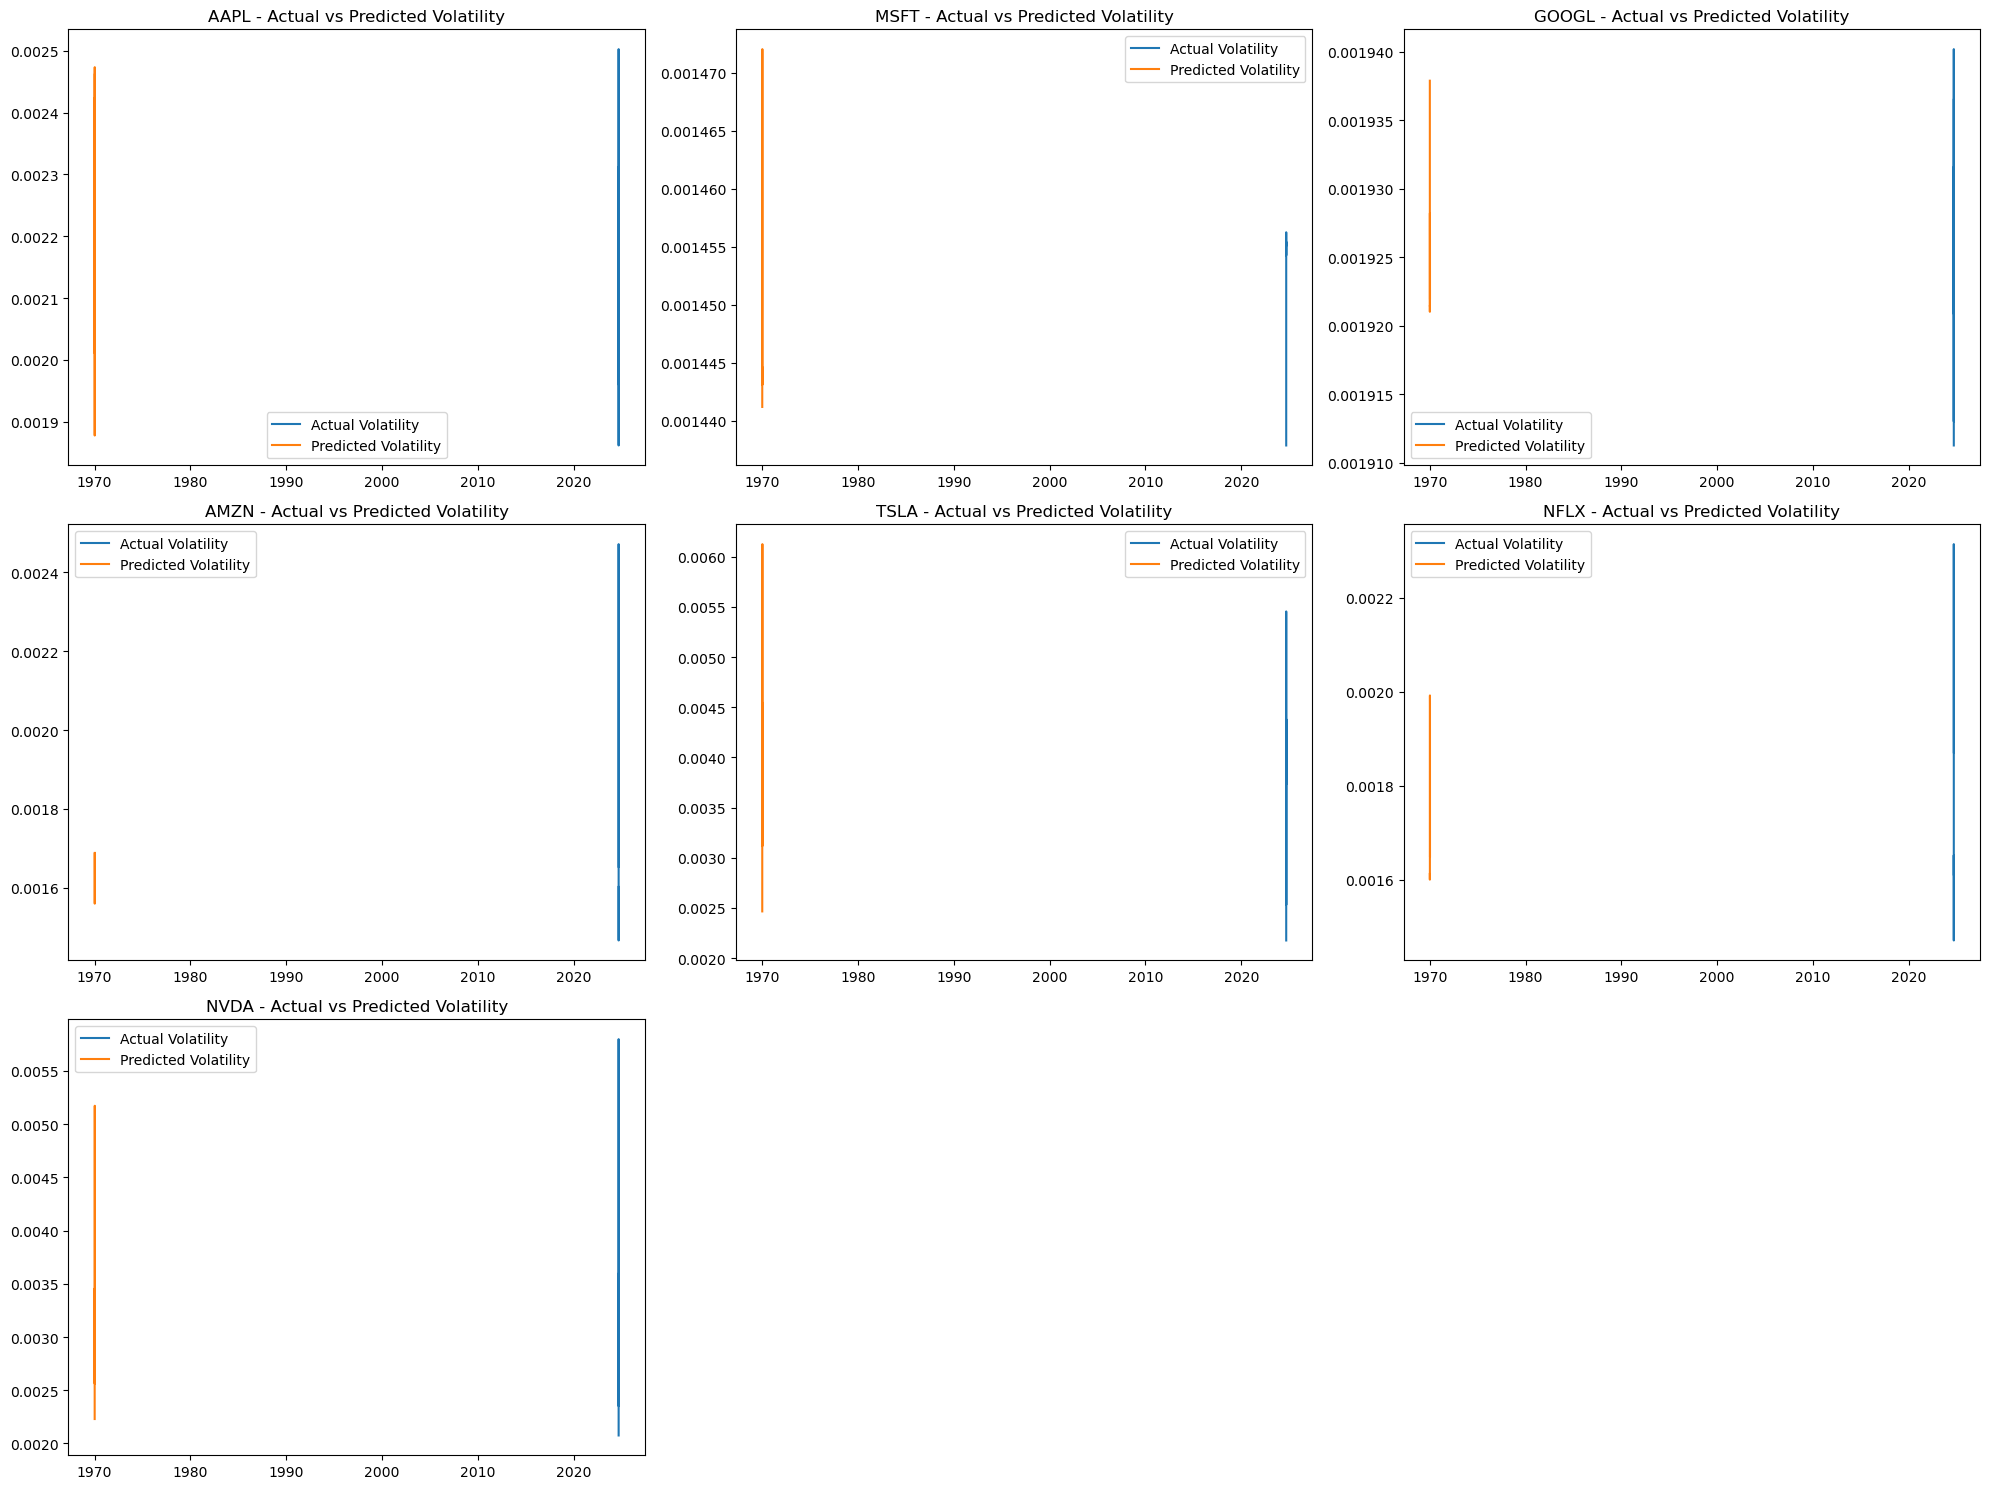

In [15]:
plt.figure(figsize=(20, 15))
for i, (company, result) in enumerate(results.items(), 1):
    plt.subplot(3, 3, i)
    plt.plot(result['y_test'], label='Actual Volatility')
    plt.plot(result['y_pred'], label='Predicted Volatility')
    plt.title(f'{company} - Actual vs Predicted Volatility')
    plt.legend()
    plt.tight_layout()

plt.savefig('volatility_predictions.png')
plt.show()

Cell 5: Trading Strategies Visualization
   Creates a subplot for each company.
   Plots cumulative returns for both the volatility-based and ML-based trading strategies.

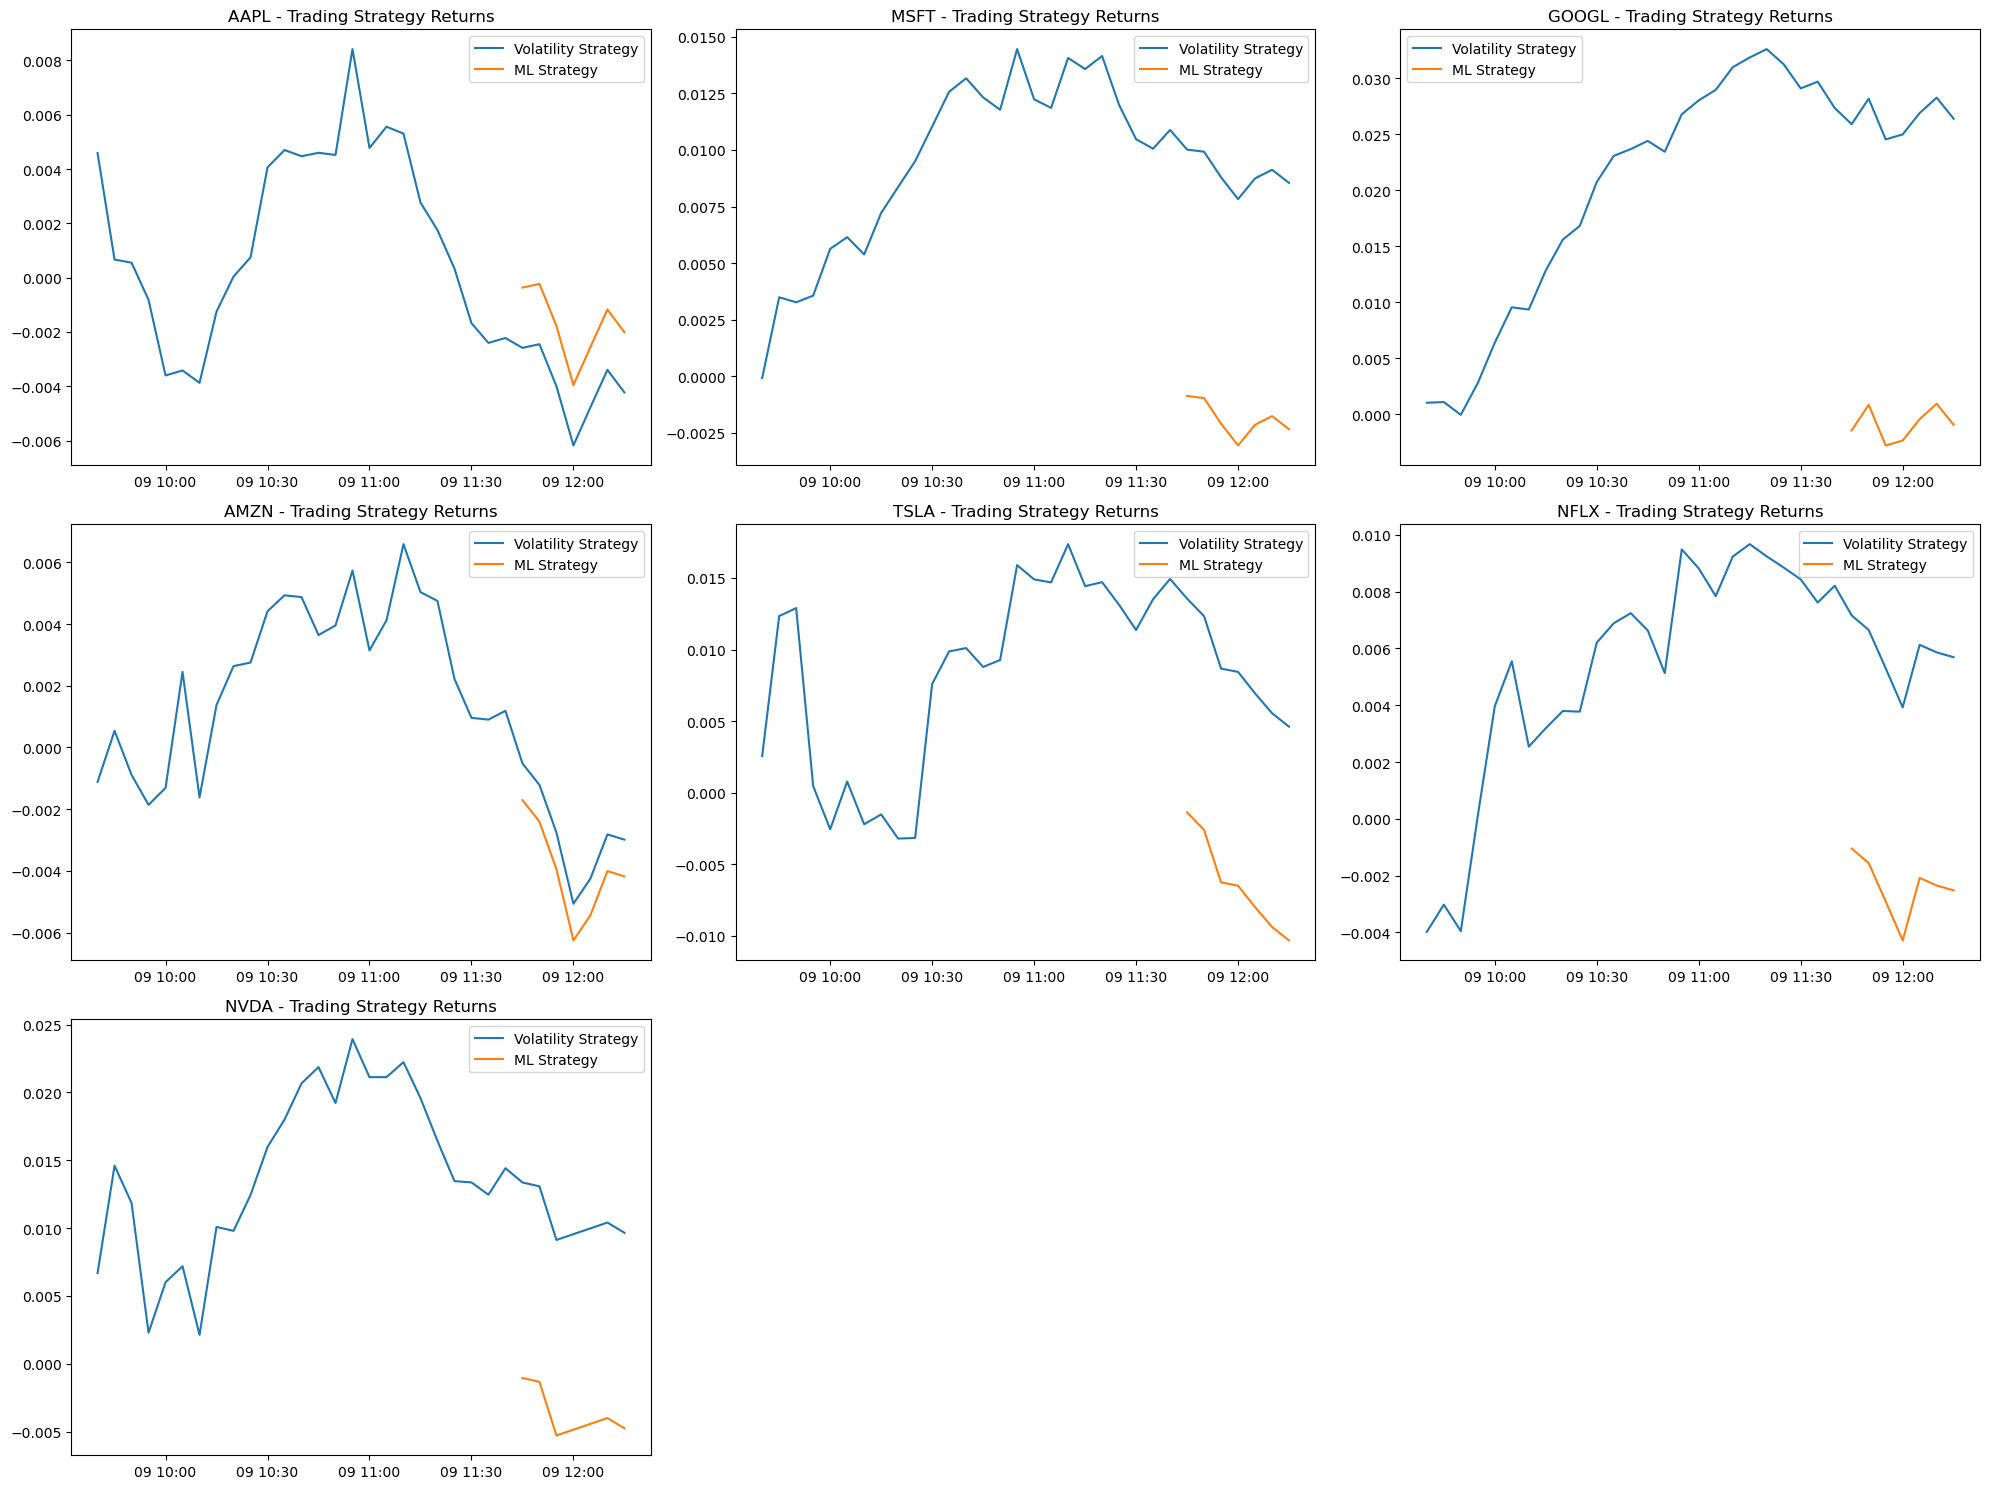

In [13]:
plt.figure(figsize=(20, 15))
for i, (company, result) in enumerate(results.items(), 1):
    plt.subplot(3, 3, i)
    plt.plot(result['vol_strategy_returns'], label='Volatility Strategy')
    plt.plot(result['ml_strategy_returns'], label='ML Strategy')
    plt.title(f'{company} - Trading Strategy Returns')
    plt.legend()
    plt.tight_layout()

plt.savefig('trading_strategies.png')
plt.show()

Cell 6: Results Summary  
Prints a summary of results for each company, including 
Mean Squared Error of the volatility predictions  .
Summary of the GARCH model parameter  s.
Final returns for both trading strategies.

In [17]:
print("\nSummary of Results:")
for company, result in results.items():
    print(f"{company}:")
    print(f"  Mean Squared Error: {result['mse']:.6f}")
    print(f"  GARCH model summary:")
    print(result['garch_results'].summary().tables[1])
    print(f"  Volatility Strategy Final Return: {result['vol_strategy_returns'].iloc[-1]:.4f}")
    print(f"  ML Strategy Final Return: {result['ml_strategy_returns'].iloc[-1]:.4f}")
    print("\n")


Summary of Results:
AAPL:
  Mean Squared Error: 0.000000
  GARCH model summary:
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.3174e-05  4.342e-06      3.034  2.411e-03 [4.664e-06,2.168e-05]
  Volatility Strategy Final Return: -0.0042
  ML Strategy Final Return: -0.0020


MSFT:
  Mean Squared Error: 0.000000
  GARCH model summary:
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -1.5490e-04  2.327e-07   -665.777      0.000 [-1.554e-04,-1.544e-04]
  Volatility Strategy Final Return: 0.0085
  ML Strategy Final Return: -0.0023


GOOGL:
  Mean Squared Error: 0.000000
  GARCH model summary:
       